In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.optimize import minimize
from datetime import datetime, timedelta

In [8]:
import numpy as np
import scipy
import sklearn

print("Numpy version:", np.__version__)
print("Scipy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)


Numpy version: 2.0.2
Scipy version: 1.13.1
Scikit-learn version: 1.6.1


In [11]:
# ==========================
# Step 1: Data Collection (Live Data Integration)
# ==========================

# def fetch_sp500_tickers():
#     url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
#     sp500_table = pd.read_html(url)[0]
#     return sp500_table[['Symbol', 'GICS Sector']]

# def fetch_stock_data(tickers, start_date, end_date):
#     data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
#     return data.dropna(axis=1)

# sp500_companies = fetch_sp500_tickers()
# tickers = sp500_companies['Symbol'].tolist()

# start_date = "2018-01-01"
# end_date = datetime.today().strftime('%Y-%m-%d')  # Get latest available data
# data = fetch_stock_data(tickers, start_date, end_date)


# from datetime import datetime
# import yfinance as yf
# import pandas as pd

# import pandas as pd
# import yfinance as yf
# from datetime import datetime

def fetch_sp500_tickers():
    """Fetch S&P 500 tickers from Wikipedia."""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_table = pd.read_html(url)[0]
    return sp500_table[['Symbol', 'GICS Sector']]

def clean_tickers(tickers):
    """Fix tickers with dot notation for Yahoo Finance."""
    return [t.replace('.', '-') for t in tickers]  # BRK.B → BRK-B

def filter_valid_tickers(tickers, start_date, end_date):
    """Check which tickers have valid data on Yahoo Finance."""
    valid_tickers = []
    for ticker in tickers:
        try:
            data = yf.Ticker(ticker).history(start=start_date, end=end_date)
            if not data.empty:
                valid_tickers.append(ticker)
            else:
                print(f"Skipping {ticker}: No data found.")
        except Exception as e:
            print(f"Skipping {ticker}: {e}")
    return valid_tickers

def fetch_stock_data(tickers, start_date, end_date):
    """Download stock data for valid tickers."""
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # Check if 'Adj Close' exists in the returned data
    if 'Adj Close' in data:
        return data['Adj Close'].dropna(axis=1)  # Remove columns with NaN
    else:
        print("Warning: 'Adj Close' column not found in data. Returning raw data.")
        return data  # Return the whole DataFrame for debugging

# Fetch tickers and clean them
sp500_companies = fetch_sp500_tickers()
tickers = clean_tickers(sp500_companies['Symbol'].tolist())

# Define date range
start_date = "2018-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Validate tickers and fetch data
valid_tickers = filter_valid_tickers(tickers, start_date, end_date)
data = fetch_stock_data(valid_tickers, start_date, end_date)

# Display the first few rows
print(data.head())


Could not get exchangeTimezoneName for ticker 'ETR' reason: 'chart'
$ETR: possibly delisted; no timezone found


Skipping ETR: No data found.


$HWM: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping HWM: No data found.


$J: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping J: No data found.


$LEN: possibly delisted; no price data found  (1d 2018-01-01 -> 2025-02-09)


Skipping LEN: No data found.


[*********************100%***********************]  499 of 499 completed


Price           Close                                                   \
Ticker              A       AAPL       ABBV ABNB        ABT       ACGL   
Date                                                                     
2018-01-02  64.180229  40.524342  71.669937  NaN  51.776566  27.988113   
2018-01-03  65.813217  40.517292  72.791458  NaN  51.891056  28.013470   
2018-01-04  65.319550  40.705490  72.376343  NaN  51.802982  28.118069   
2018-01-05  66.363876  41.168938  73.636269  NaN  51.952717  28.007132   
2018-01-08  66.506332  41.016026  72.456459  NaN  51.802982  28.010302   

Price                                                     ...  Volume  \
Ticker             ACN        ADBE        ADI        ADM  ...     WTW   
Date                                                      ...           
2018-01-02  138.659622  177.699997  79.129036  32.879116  ...  817700   
2018-01-03  139.299576  181.039993  80.110710  32.624870  ...  771200   
2018-01-04  140.948990  183.220001  80.023

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# ==========================
# Step 2: Feature Engineering (Risk, Liquidity & Macro)
# ==========================
# Compute returns and volatility
returns = data.pct_change().dropna()
volatility = returns.rolling(window=20).std().dropna()

def compute_beta(stock_returns, market_returns):
    """Calculate Beta for each stock."""
    if stock_returns.isna().sum() > 0 or market_returns.isna().sum() > 0:
        return np.nan  # Handle missing values
    
    covariance = np.cov(stock_returns.dropna(), market_returns.dropna())[0, 1]
    market_variance = np.var(market_returns.dropna())

    return covariance / market_variance if market_variance > 0 else np.nan

# Approximate S&P 500 market return
sp500_returns = returns.mean(axis=1)

# Compute feature matrix
features = pd.DataFrame({
    "mean_return": returns.mean() * 252,
    "volatility": volatility.mean(),
    "cumulative_return": (data.iloc[-1] / data.iloc[0]) - 1,
    "sharpe_ratio": returns.mean() / (returns.std() + 1e-8),  # Avoid div-by-zero
    "sortino_ratio": returns.mean() / (returns[returns < 0].std() + 1e-8),  # Avoid div-by-zero
    "max_drawdown": (data / data.cummax() - 1).min(),
    "var_95": returns.quantile(0.05),
    "beta": [compute_beta(returns[ticker], sp500_returns) for ticker in returns.columns],
    "liquidity": data.mean(),  # Approximate by average price
})

# Handle Inf and NaNs before scaling
features.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN
features.dropna(inplace=True)  # Drop rows with NaN values

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame
features_scaled_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)

# Display first few rows
print(features_scaled_df.head())


C:\Users\bhavy\AppData\Local\Temp\ipykernel_36620\392514591.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


              mean_return  volatility  cumulative_return  sharpe_ratio  \
Price Ticker                                                             
Close A         -0.461323   -0.489201          -0.067621     -0.047251   
      AAPL      -0.488133   -0.499602           1.201692     -0.772085   
      ABBV      -0.457299   -0.487787           0.082550     -0.036496   
      ABT       -0.443102   -0.508513           0.019517      0.721704   
      ACGL      -0.487660   -0.486642           0.340338     -0.767860   

              sortino_ratio  max_drawdown    var_95      beta  liquidity  
Price Ticker                                                              
Close A           -0.229715      0.805469  0.505174 -0.469136  -0.115417  
      AAPL        -0.741814      0.993460  0.484087 -0.464818  -0.115415  
      ABBV        -0.421039      0.700538  0.526798 -0.467043  -0.115417  
      ABT          0.235046      1.200175  0.542720 -0.476886  -0.115418  
      ACGL        -0.737378    

In [14]:
# from sklearn.cluster import AgglomerativeClustering, DBSCAN
# from sklearn.mixture import GaussianMixture
# ==========================
# Step 3: Advanced Clustering (Hierarchical + GMM + DBSCAN)
# ==========================
# Use scaled features for clustering
X_scaled = features_scaled_df.copy()

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=10, linkage='ward')
X_scaled['hierarchical_cluster'] = hierarchical.fit_predict(features_scaled_df)

# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)
X_scaled['gmm_cluster'] = gmm.fit_predict(features_scaled_df)

# DBSCAN Clustering (Density-based)
dbscan = DBSCAN(eps=1.5, min_samples=5)
X_scaled['dbscan_cluster'] = dbscan.fit_predict(features_scaled_df)

# Save Clustering Data
X_scaled.to_csv("advanced_clustered_data.csv")

# Display first few rows of results
print(X_scaled.head())


              mean_return  volatility  cumulative_return  sharpe_ratio  \
Price Ticker                                                             
Close A         -0.461323   -0.489201          -0.067621     -0.047251   
      AAPL      -0.488133   -0.499602           1.201692     -0.772085   
      ABBV      -0.457299   -0.487787           0.082550     -0.036496   
      ABT       -0.443102   -0.508513           0.019517      0.721704   
      ACGL      -0.487660   -0.486642           0.340338     -0.767860   

              sortino_ratio  max_drawdown    var_95      beta  liquidity  \
Price Ticker                                                               
Close A           -0.229715      0.805469  0.505174 -0.469136  -0.115417   
      AAPL        -0.741814      0.993460  0.484087 -0.464818  -0.115415   
      ABBV        -0.421039      0.700538  0.526798 -0.467043  -0.115417   
      ABT          0.235046      1.200175  0.542720 -0.476886  -0.115418   
      ACGL        -0.7373

In [17]:
# import numpy as np
# from scipy.optimize import minimize


# ==========================
# Step 4: Portfolio Optimization (Mean-Variance)
# ==========================

def portfolio_performance(weights, returns):
    """Calculate portfolio return, volatility, and Sharpe ratio."""
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # Avoid division by zero
    sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0
    return portfolio_return, portfolio_volatility, sharpe_ratio



In [18]:
def minimize_sharpe(weights, returns):
    """Objective function to minimize negative Sharpe ratio."""
    return -portfolio_performance(weights, returns)[2]  # Minimize negative Sharpe



In [19]:
def optimize_portfolio(returns):
    """Optimize portfolio allocation using Mean-Variance optimization."""
    returns = returns.dropna(axis=1)  # Ensure valid returns data

    num_assets = len(returns.columns)
    initial_weights = np.ones(num_assets) / num_assets
    bounds = [(0, 1) for _ in range(num_assets)]  # Weight constraints (0 to 1)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights must be 1

    optimized = minimize(minimize_sharpe, initial_weights, args=(returns,), 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimized.x if optimized.success else None  # Return weights if optimization is successful



In [20]:
# Select stocks from hierarchical clustering (e.g., cluster 0)
selected_cluster = 0
selected_stocks = X_scaled[X_scaled['hierarchical_cluster'] == selected_cluster].index
cluster_returns = returns[selected_stocks]  # Use only clustered stocks



In [21]:

# Optimize portfolio for selected cluster
optimized_weights = optimize_portfolio(cluster_returns)



In [22]:
# Display optimized portfolio weights
portfolio_allocation = pd.Series(optimized_weights, index=cluster_returns.columns)
print("Optimized Portfolio Allocation:")
print(portfolio_allocation)

Optimized Portfolio Allocation:
Price  Ticker
Close  ABT       1.129009e-02
       ACN       2.644893e-03
       ADP       1.181757e-10
       ADSK      0.000000e+00
       AEE       2.386078e-02
                     ...     
Open   WMT       5.613280e-03
       WTW       1.902605e-10
       WY        0.000000e+00
       XEL       4.838965e-03
       ZBRA      0.000000e+00
Length: 694, dtype: float64


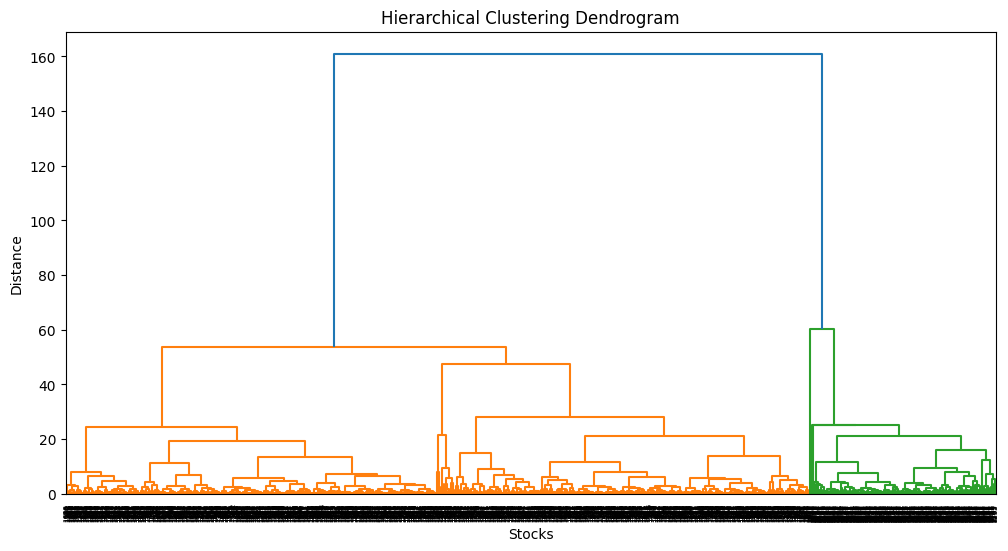

In [23]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# from scipy.cluster.hierarchy import dendrogram, linkage
# from sklearn.manifold import TSNE

# Ensure clustering results exist
if 'hierarchical_cluster' not in X_scaled.columns:
    raise ValueError("Clustering results not found. Run Step 3 before visualization.")

# ==========================
# Dendrogram (Hierarchical Clustering)
# ==========================
plt.figure(figsize=(12, 6))
dendrogram(linkage(features_scaled_df, method='ward'))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Stocks")
plt.ylabel("Distance")
plt.show()



In [39]:
# import plotly.express as px
from sklearn.manifold import TSNE

# Ensure we don't have duplicate 'Stock' columns before resetting index
if 'Stock' in X_scaled.columns:
    X_scaled = X_scaled.drop(columns=['Stock'])

# Reset index and rename it to 'Stock'
X_scaled = X_scaled.reset_index().rename(columns={'index': 'Stock'})

# t-SNE Transformation
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', random_state=42)
tsne_results = tsne.fit_transform(features_scaled_df)

# Add t-SNE results to the DataFrame
X_scaled['tsne_1'] = tsne_results[:, 0]
X_scaled['tsne_2'] = tsne_results[:, 1]

# Interactive Scatter Plot (color by hierarchical cluster)
fig = px.scatter(X_scaled, x='tsne_1', y='tsne_2', 
                 color=X_scaled['hierarchical_cluster'].astype(str), 
                 title="t-SNE Visualization of Clusters", 
                 hover_name="Stock")  # Use renamed index column
# fig.show()
fig.show(renderer="browser")

C:\Users\bhavy\AppData\Local\Temp\ipykernel_36620\410086475.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




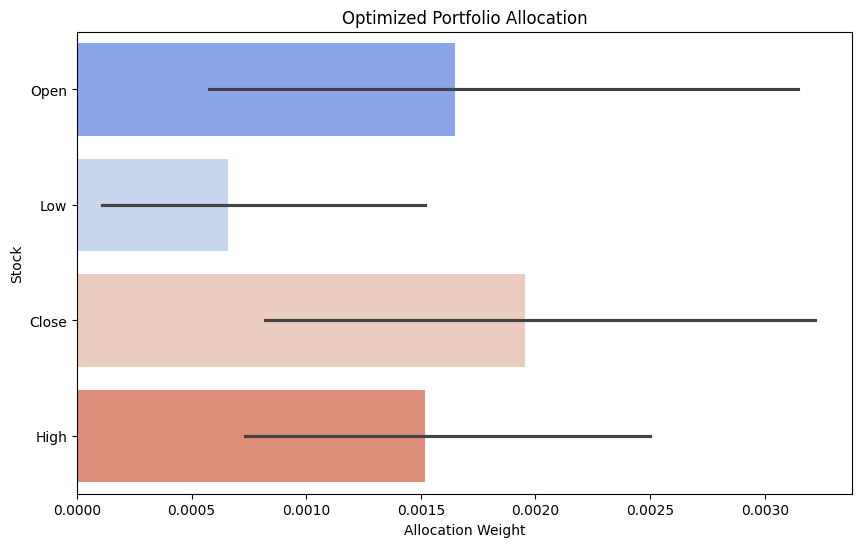

In [37]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# ==========================
# Portfolio Allocation Visualization
# ==========================
# Ensure `optimized_weights` exist
if optimized_weights is not None:
    # Convert MultiIndex to a flat index (if needed)
    stock_names = [col[0] if isinstance(col, tuple) else col for col in cluster_returns.columns]

    # Create allocation DataFrame
    allocation_df = pd.DataFrame({'Stock': stock_names, 'Weight': optimized_weights})
    allocation_df = allocation_df.sort_values(by='Weight', ascending=False)

    # Plot the allocation
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Weight', y='Stock', data=allocation_df, palette="coolwarm")
    plt.title("Optimized Portfolio Allocation")
    plt.xlabel("Allocation Weight")
    plt.ylabel("Stock")
    plt.show()
else:
    print("Portfolio optimization failed. No visualization available.")
